In [1]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 8.9 MB/s eta 0:00:00


In [2]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
def heat_eq_exact_solution(x, y, t, dy):
    """Returns the exact solution for a given x and t (for sinusoidal initial conditions).

    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    m = 10; summation = 0;

    for i in range(m):
      summation = summation + np.sum(np.exp(-np.square((i+1)*np.pi/dy))*(1-np.power(-1,(i+1)))/((i+1)*np.pi)*np.sin((i+1)*np.pi*y/dy));

    exact = 1 + 2 * (1/3 - 1) * summation;
    return exact;


def gen_exact_solution():
    """Generates exact solution for the heat equation for the given values of x and t."""
    # Number of points in each dimension:
    x_dim, y_dim, t_dim = (32, 32, 10)

    # Bounds of 'x' and 't':
    x_min, y_min, t_min = (0, 0, 0.0)
    x_max, y_max, t_max = (L, L, 1.0)

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    y = np.linspace(y_min, y_max, num=y_dim).reshape(y_dim, 1)
    usol = np.zeros((x_dim, y_dim, t_dim)).reshape(x_dim, y_dim, t_dim)

    dy = y[1] - y[0];
    # Obtain the value of the exact solution for each generated point:
    for i in range(x_dim):
        for j in range(y_dim):
          for k in range(t_dim):
              usol[i][j][k] = heat_eq_exact_solution(x[i], y[j], t[k], dy)

    # Save solution:
    np.savez("heat_eq_data", x=x, y=y, t=t, usol=usol)


def gen_testdata():
    """Import and preprocess the dataset with the exact solution."""
    # Load the data:
    data = np.load("heat_eq_data.npz")
    # Obtain the values for t, x, and the excat solution:
    t, x, y, exact = data["t"], data["x"], data["y"], data["usol"].T
    # Process the data and flatten it out (like labels and features):
    xx, yy, tt = np.meshgrid(x, y, t)
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    u = exact.flatten()[:, None]
    return X, u

In [4]:
# Problem parameters:
a = 0.1  # Thermal diffusivity
L = 1  # Length of the bar
n = 1  # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
gen_exact_solution()

In [5]:
def pde(x, u):
    """Expresses the PDE residual of the heat equation."""
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    return du_t - a * (du_xx + du_yy)

In [6]:
# Computational geometry:
geom = dde.geometry.Rectangle([0,0], [L,L])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [22]:
# Initial and boundary conditions:
def boundary_top(x, on_boundary):
  return on_boundary and np.isclose(x[1],1);

def boundary_bottom(x, on_boundary):
  return on_boundary and np.isclose(x[1],0);

def boundary_right(x, on_boundary):
  return on_boundary and np.isclose(x[0],1);

def boundary_left(x, on_boundary):
  return on_boundary and np.isclose(x[0],0);

def func_vertical(x):
  return np.zeros((len(x),1), dtype=np.float32);

def func_horizontal(x):
  return np.ones((len(x),1), dtype=np.float32);

def func_init(x):
  return np.ones((len(x),1), dtype=np.float32)/3;

ic = dde.icbc.IC(geomtime, func_init, lambda _, on_initial: on_initial)
bc_1 = dde.icbc.DirichletBC(geomtime, func_horizontal, boundary_right)
bc_2 = dde.icbc.DirichletBC(geomtime, func_horizontal, boundary_left)
bc_3 = dde.icbc.NeumannBC(geomtime, func_vertical, boundary_top)
bc_4 = dde.icbc.NeumannBC(geomtime, func_vertical, boundary_bottom)

In [23]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_1, bc_2, bc_3, bc_4, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=2540,
)
net = dde.nn.FNN([3] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

Dummy

In [19]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
# ic = dde.icbc.IC(
#     geomtime,
#     lambda x: np.sin(np.pi * x[:, 0:1])*np.sin(np.pi * x[:, 1:2]),
#     lambda _, on_initial: on_initial,
#                     )
ic = dde.icbc.IC(geomtime, func_init, lambda _, on_initial: on_initial)

In [20]:
# definisi PDP dan konfigurasi neural network
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=5000,
    num_boundary=200,
    num_initial=400,
    num_test=5000,
)
net = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

==============

In [24]:
# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.065593 s

'compile' took 0.858309 s

Training model...

0         [5.67e-02, 8.68e-01, 6.36e-01, 2.84e-02, 6.89e-03, 1.12e-01][5.39e-02, 8.68e-01, 6.36e-01, 2.84e-02, 6.89e-03, 1.12e-01][]  
1000      [6.24e-03, 1.40e-02, 6.78e-03, 1.68e-02, 3.23e-04, 4.62e-02][3.93e-03, 1.40e-02, 6.78e-03, 1.68e-02, 3.23e-04, 4.62e-02][]  
2000      [4.25e-03, 1.36e-02, 4.99e-03, 1.23e-02, 1.15e-04, 3.83e-02][2.67e-03, 1.36e-02, 4.99e-03, 1.23e-02, 1.15e-04, 3.83e-02][]  
3000      [6.70e-03, 9.54e-03, 4.43e-03, 5.75e-03, 2.95e-04, 1.98e-02][3.55e-03, 9.54e-03, 4.43e-03, 5.75e-03, 2.95e-04, 1.98e-02][]  
4000      [4.28e-03, 2.90e-03, 2.32e-03, 5.05e-04, 2.55e-04, 6.77e-03][2.19e-03, 2.90e-03, 2.32e-03, 5.05e-04, 2.55e-04, 6.77e-03][]  
5000      [2.13e-03, 2.25e-03, 1.49e-03, 2.32e-04, 1.01e-04, 4.45e-03][8.10e-04, 2.25e-03, 1.49e-03, 2.32e-04, 1.01e-04, 4.45e-03][]  
6000      [1.93e-03, 2.07e-03, 1.11e-03, 1.75e-04, 4.58e-05,

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


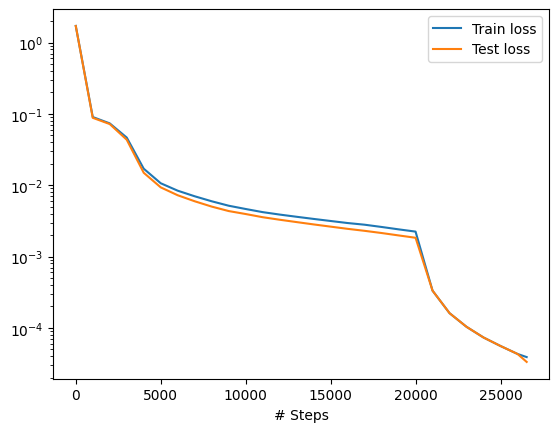

Mean residual: 0.004601228
L2 relative error: 0.41483524102804237


In [27]:
# Plot/print the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X, u_true = gen_testdata()
u_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(u_true, u_pred))
np.savetxt("test.dat", np.hstack((X, u_true, u_pred)))

In [33]:
import matplotlib.pyplot as plt
from matplotlib import cm

In [31]:
y_PINN = u_pred

IndexError: ignored

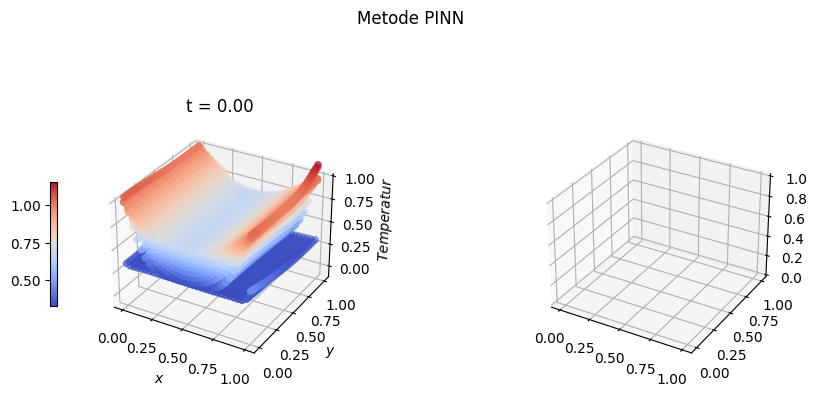

In [34]:
# Plot hasil yang diperoleh
fig = plt.figure(figsize=(11,11))
plt.suptitle("Metode PINN")

ax = fig.add_subplot(3, 2, 1, projection='3d')
surf = ax.scatter(X[0:10000, 0], X[0:10000, 1], y_PINN[0:10000], c=y_PINN[0:10000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[0, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 2, projection='3d')
surf = ax.scatter(X[200000:210000, 0], X[200000:210000, 1], y_PINN[200000:210000], c=y_PINN[200000:210000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[200000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 3, projection='3d')
surf = ax.scatter(X[400000:410000, 0], X[400000:410000, 1], y_PINN[400000:410000], c=y_PINN[400000:410000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[400000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 4, projection='3d')
surf = ax.scatter(X[600000:610000, 0], X[600000:610000, 1], y_PINN[600000:610000], c=y_PINN[600000:610000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[600000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 5, projection='3d')
surf = ax.scatter(X[800000:810000, 0], X[800000:810000, 1], y_PINN[800000:810000], c=y_PINN[800000:810000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[800000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 6, projection='3d')
surf = ax.scatter(X[990000:1000000, 0], X[990000:1000000, 1], y_PINN[990000:1000000], c=y_PINN[990000:1000000], cmap=cm.coolwarm)
ax.set_title("t = {:.2f}".format(X[990000, 2]))
ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

plt.tight_layout()
plt.savefig("PINN2d.png", dpi=300)